# **Inversión 2D con Datos Reales**
**Elaborador por:** \
Johan Enrique Páez Romero 2210631 \
Ivan Camilo Caballero Jaimes 2210625 \
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Librerías

In [ ]:
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
## mtpy 1.1.5
## mtpy-v2 2.0.7
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import unittest
from scipy.constants import mu_0
from discretize.tests import check_derivative
import discretize
import matplotlib.patheffects as pe
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.electromagnetics.static import utils as sutils
from SimPEG import (
    maps, utils, optimization, objective_function, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
## ERROR-----> 
from pymatsolver import Solver
# Antes -> "import Pardiso"
# Corregir -> "import Solver"

from scipy.spatial import cKDTree
from scipy.stats import norm
# from dask.distributed import Client, LocalCluster
import dill
from geoana.em.fdem import skin_depth
import discretize.utils as dis_utils
import warnings
warnings.filterwarnings("ignore")

## Crear "Transfer Function MTH5"

In [32]:
tf_path = Path(r"C:/Users/Ivan Camilo/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Anything/001 - U/7to Semestre 14.2 GB/Semilleros/SIGAC/Proyectos/Magnetotelúrica/data/transfer_functions/broadband3")
tf_path.exists()

True

In [33]:
print(", ".join([fn.name for fn in tf_path.glob("*.edi")]))

SA225_2.edi, SA227.edi, SA242.edi, SA243.edi, SA246.edi, SA247.edi, SA248.edi, SA249.edi, SA250.edi, SA251.edi, SA26W_2.edi, SA270.edi, SA271.edi, SA272.edi, SA273.edi, SA274_2.edi, SA275.edi, SA276.edi, SA277.edi, SA293-2.edi, SA294.edi, SA295.edi, SA296.edi, SA297.edi, SA298.edi, SA299.edi, SA300.edi, SA301.edi, SA319.edi, SA320_2.edi, SA321.edi, SA322.edi, SA323.edi, SA324.edi, SA325_2.edi, SA326N.edi, SA326S.edi, SA344.edi, SA345.edi, SA346.edi, SA347.edi, SA348.edi, SA350.edi, SA351.edi


In [34]:
with MTCollection() as mc:
    mc.open_collection(tf_path.joinpath("musgraves_tf.h5"))
    mc.add_tf(mc.make_file_list(tf_path))

24:07:21T21:24:54 | INFO | line:679 |mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3\musgraves_tf.h5 in mode a
24:07:21T21:24:54 | WARNING | line:1058 |mth5.mth5 | get_survey | /Experiment/Surveys/Musgraves_SA does not exist, check survey_list for existing names.
24:07:21T21:26:50 | INFO | line:761 |mth5.mth5 | close_mth5 | Flushing and closing C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3\musgraves_tf.h5


In [35]:
mc.open_collection(mc.mth5_collection.filename)

24:07:21T21:26:58 | WARNING | line:328 |mth5.mth5 | filename | MTH5 file is not open or has not been created yet. Returning default name


In [36]:
mc

Working Directory: C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3
MTH5 file:         C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3\musgraves_tf.h5
	Number of Transfer Functions: 44

In [37]:
mc.mth5_collection

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: Musgraves_SA
            ----------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
                    |- Group: time_delay
                    --------------------
                    |- Group: zpk
                    -------------
                |- Group: Reports
                -----------------
                |- Group: Standards
                -------------------
                    --> Dataset: summary
                    ..........

In [38]:
mc.master_dataframe

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,SA225_2,Musgraves_SA,-28.50111,134.47621,219.0,SA225_2,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
1,SA26W2,Musgraves_SA,-28.49435,129.33328,335.0,SA26W2,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
2,SA274_2,Musgraves_SA,-27.55531,130.55070,504.0,SA274_2,none,True,True,False,8.0,8192.020972,<HDF5 object reference>,<HDF5 object reference>
3,SA295,Musgraves_SA,-26.99104,132.50675,564.0,SA295,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
4,SA326N,Musgraves_SA,-26.21286,129.46975,646.0,SA326N,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
5,SA326S,Musgraves_SA,-26.65605,129.37950,544.0,SA326S,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
6,SAA227,Musgraves_SA,-28.49864,133.49527,211.0,SAA227,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
7,SAA242,Musgraves_SA,-28.00196,134.05853,290.0,SAA242,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
8,SAA243,Musgraves_SA,-28.07727,133.49181,256.0,SAA243,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>
9,SAA246,Musgraves_SA,-27.99918,132.00528,407.0,SAA246,none,True,True,False,8.0,16384.041943,<HDF5 object reference>,<HDF5 object reference>


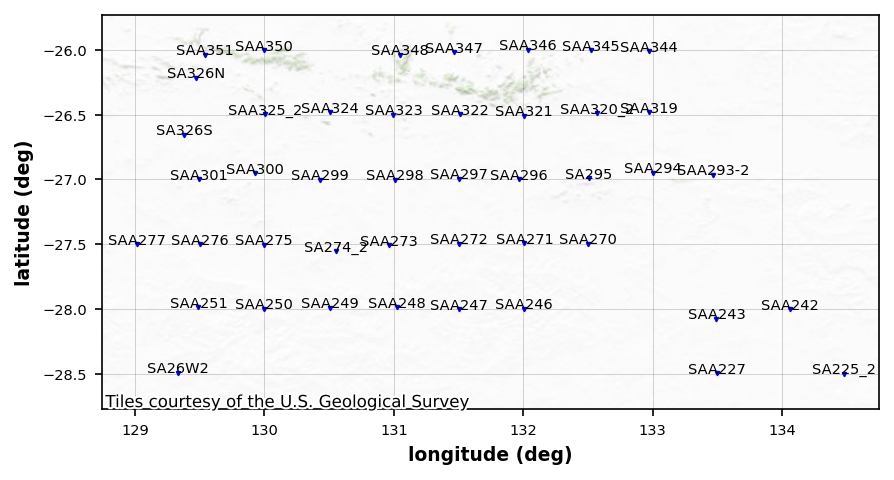

In [39]:
plot_stations = mc.plot_stations()

In [ ]:
#mc.apply_bbox(lon_min, lon_max, lat_min, lat_max)
#mc.apply_bbox(129, 130, -27, -26)

In [46]:
mc.close_collection()

24:07:21T21:32:55 | WARNING | line:328 |mth5.mth5 | filename | MTH5 file is not open or has not been created yet. Returning default name
24:07:21T21:32:55 | INFO | line:761 |mth5.mth5 | close_mth5 | Flushing and closing C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3\musgraves_tf.h5


## Cargar datos desde MTH5

In [47]:
with MTCollection() as mc:
    #mc.open_collection(Path('../../../home/005/jp0633/mt_examples/notebooks/simpeg/2d_forward_mth5.h5'))
    mc.open_collection(Path(r"C:/Users/Ivan Camilo/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Anything/001 - U/7to Semestre 14.2 GB/Semilleros/SIGAC/Proyectos/Magnetotelúrica/data/transfer_functions/broadband3/musgraves_tf.h5"))
    mt_data = mc.to_mt_data()
    mt_data.remove_station("SAA300_pred", "Musgraves_SA")
    mt_data.utm_crs = 28353
    profile_mt_data = mt_data.get_profile(129, -27, 134, -27, 8000)

24:07:21T21:33:16 | INFO | line:761 |mth5.mth5 | close_mth5 | Flushing and closing C:\Users\Ivan Camilo\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\Anything\001 - U\7to Semestre 14.2 GB\Semilleros\SIGAC\Proyectos\Magnetotelúrica\data\transfer_functions\broadband3\musgraves_tf.h5


In [48]:
mt_df = profile_mt_data.to_dataframe()
mt_df.loc[mt_df.station == "SAA301", "profile_offset"]  *= -1
mt_df = mt_df.sort_values(["profile_offset", "period"])

In [49]:
mt_df[["survey", "station", "profile_offset", "period"]]

,survey,station,profile_offset,period
46,Musgraves_SA,SAA301,-42748.727314,8.000000
47,Musgraves_SA,SAA301,-42748.727314,10.666667
48,Musgraves_SA,SAA301,-42748.727314,16.000000
49,Musgraves_SA,SAA301,-42748.727314,21.333333
50,Musgraves_SA,SAA301,-42748.727314,32.000000
...,...,...,...,...
202,Musgraves_SA,SAA293-2,344424.855050,4096.010486
203,Musgraves_SA,SAA293-2,344424.855050,5461.198187
204,Musgraves_SA,SAA293-2,344424.855050,8192.020972
205,Musgraves_SA,SAA293-2,344424.855050,10922.634976


In [55]:
n_stations = mt_df.station.unique().size

# make a station array (x, z)
rx_locs = np.c_[mt_df.profile_offset.unique(), np.zeros(n_stations)]

frequencies = 1./mt_df.period.unique()

app_rho_te = np.zeros((frequencies.size, rx_locs.shape[0]))
app_rho_tm = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_te = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_tm = np.zeros((frequencies.size, rx_locs.shape[0]))
for index, station in enumerate(mt_df.station.unique()):
    sdf = mt_df[mt_df.station == station]
    sdf.sort_values("period")
    app_rho_te[:, index] = sdf.res_xy
    app_rho_tm[:, index] = sdf.res_yx
    phase_te[:, index] = sdf.phase_xy
    phase_tm[:, index] = sdf.phase_yx
    

In [57]:
plot_stations = mc.plot_stations()

In [58]:
tf = mc.get_tf("SA227")
plot_response = tf.plot_mt_response() # vemos la respuesta de los datos

AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
#Para ello primero creamos un dataframe con 3 columnas que contengan los datos de frecuencia, rho_app y phase
df=pd.DataFrame({'frequencies': frequencies, 'app_rho_te': app_rho_te, 'app_rho_tm': app_rho_tm,'phase_te': phase_te, 'phase_tm': phase_tm})
df

In [ ]:
bool_list = (df['frequencies'] > 1).tolist()
print(bool_list[54])

In [ ]:
df = df.iloc[:54]
print(df.tail())
df

In [ ]:
def calcular_profundidades_piel(df):
    # Calcular la profundidad de piel para cada fila
    df['skindepth_te'] = 503 * np.sqrt(df['app_rho_te'] / df['frequencies'])
    df['skindepth_tm'] = 503 * np.sqrt(df['app_rho_tm'] / df['frequencies'])

    return df
df=calcular_profundidades_piel(df)
print(df.head())
d_max_te = df.iloc[0]['skindepth_te']
d_min_te = df.iloc[-1]['skindepth_te']

d_max_tm = df.iloc[0]['skindepth_tm']
d_min_tm = df.iloc[-1]['skindepth_tm']

print(f"La profundidad mínima es: {d_min_te:.2f} y {d_min_tm:.2f}")
print(f"La profundidad máxima es: {d_max_te:.2f} y {d_max_tm:.2f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.loglog(df['frequencies'], df['skindepth_te'], marker='o', linestyle='-', color='b', label='Profundidad de piel')
plt.loglog(df['frequencies'], df['skindepth_tm'], marker='o', linestyle='-', color='g', label='Profundidad de piel')

plt.scatter(df.iloc[0]['frequencies'], d_max_te, color='r', label=f'Profundidad máxima: {d_max_te:.2f} m', zorder=5)
plt.scatter(df.iloc[-2]['frequencies'], d_min_te, color='k', label=f'Profundidad mínima: {d_min_te:.2f} m', zorder=5)

plt.scatter(df.iloc[0]['frequencies'], d_max_tm, color='r', label=f'Profundidad máxima: {d_max_tm:.2f} m', zorder=5)
plt.scatter(df.iloc[-1]['frequencies'], d_min_tm, color='k', label=f'Profundidad mínima: {d_min_tm:.2f} m', zorder=5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Profundidad de piel (m)')
plt.title('Profundidad de piel vs. Frecuencia')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
frequencies = df["frequencies"].values
app_rho_te = df["app_rho_te"].values
app_rho_tm = df["app_rho_tm"].values
phase_te = df["phase_te"].values
phase_tm = df["phase_tm"].values

## Inversión

In [64]:
def generate_2d_mesh_for_mt( # Parámetros
    rx_locs, #Ubicación de los receptores
    frequencies, #Frecuencias de la señal
    sigma_background,  # Conductividad de fondo
    z_factor_max=5, # Los demas son factores y límites para configuar las dimensiones de las celdas del mesh
    z_factor_min=5,
    pfz_down = 1.2,
    pfz_up = 1.5,
    npadz_up = 5,
    x_factor_max = 2,
    spacing_factor = 4,
    pfx = 1.5,
    n_max=1000
):
    # get minimum cell size (first layer thickness)
    dz_min = np.round(skin_depth(frequencies.max(), sigma_background) / z_factor_max) 
    lz = skin_depth(sigma_background, frequencies.min()) * z_factor_max
    
    # Setting the domain length in subsurface
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum() > lz:
            break
    # create air layers
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    
    # combine air and subsurface
    hz = np.r_[hz_down, hz_up]
    
    # Setting the cells in lateral dimension
    # station spacing
    d_station = np.diff(rx_locs[:,0]).min()
    # minimum cell width
    dx_min = np.round(d_station/spacing_factor)
    print(dx_min)
    # survey span
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    
    # make padding cells
    lx_pad = skin_depth(sigma_background, frequencies.min()) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.unpack_widths([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    # combine paddin cells with station area cells
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx+spacing_factor), (dx_min, npadx, pfx)]  
    
    # make a discretize.TensorMesh object
    mesh = discretize.TensorMesh([hx, hz])
    
    # get the lower left corner of the mesh, the origin
    mesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min() - spacing_factor * dx_min/2, -hz_down.sum()] 
    mesh.x0 = mesh.x0 + np.array([0, -mesh.nodes_y[int(np.searchsorted(mesh.nodes_y, 0))]])
    print (mesh)
    return mesh

In [65]:
nskip_freq = 7
nskip_rx = 3
relative_error =  0.30
floor_error = 1.5
alpha_s = 1e-5
alpha_y = 1/5.
alpha_z = 1.
rho_0 = 1000.
maxIter = 30
use_irls = True
p_s=2.
p_y=0.
p_z=0.

app_rho_err_tm = abs(app_rho_tm) * relative_error
app_rho_err_te = abs (app_rho_te) * relative_error
phase_err_tm = np.ones_like(phase_tm) * floor_error
phase_err_te = np.ones_like(phase_te) * floor_error

mesh = generate_2d_mesh_for_mt(
    rx_locs, 
    frequencies, 
    1e-2,
    spacing_factor=8,
    z_factor_min=10,
    z_factor_max=10,
    x_factor_max=8)
ind_active = mesh.cell_centers[:,1]<0.
print ("Rx")
print (rx_locs)
print ("Freqs")
print (frequencies)

5274.0

  TensorMesh: 4,773 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    111 -6,976,379.86  7,275,884.41  5,274.00 2,309,452.38    1.50
   y     43 -7,262,219.86     26,032.50  1,424.00 1,211,200.64    1.50


Rx
[[-42748.72731382      0.        ]
 [     0.              0.        ]
 [ 42188.2784139       0.        ]
 [100016.21784429      0.        ]
 [149263.54978962      0.        ]
 [195282.6439964       0.        ]
 [248874.95920631      0.        ]
 [298255.35716906      0.        ]
 [344424.85505037      0.        ]]
Freqs
[1.2500e-01 9.3750e-02 6.2500e-02 4.6875e-02 3.1250e-02 2.3438e-02
 1.5625e-02 1.1719e-02 7.8125e-03 5.8594e-03 3.9062e-03 2.9297e-03
 1.9531e-03 1.4648e-03 9.7656e-04 7.3242e-04 4.8828e-04 3.6621e-04
 2.4414e-04 1.8311e-04 1.2207e-04 9.1553e-05 6.1035e-05]


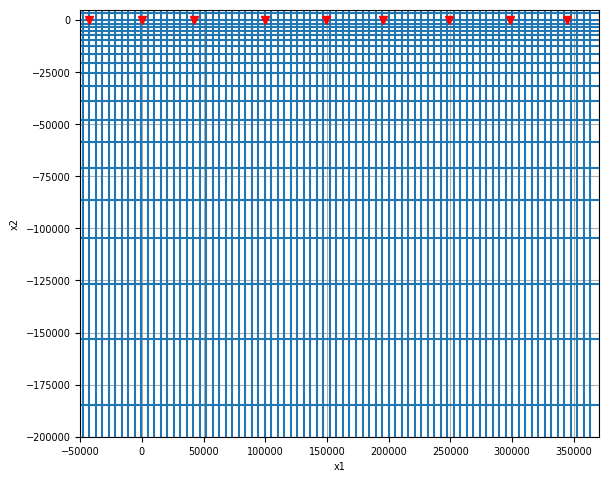

In [66]:
ax = mesh.plot_grid()
ax.set_xlim(-50000, 370000)
ax.set_ylim(-200000, 5000)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")

In [67]:
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

act_map = maps.InjectActiveCells(mesh, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh)
sigma_map = exp_map * act_map

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Solver,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Solver,
)

In [68]:
dobs_te = np.hstack((app_rho_te, phase_te)).flatten()
dobs_tm = np.hstack((app_rho_tm, phase_tm)).flatten()

std_te = np.hstack((app_rho_err_te, phase_err_te)).flatten()
std_tm = np.hstack((app_rho_err_tm, phase_err_tm)).flatten()


In [69]:
m0 = np.ones(ind_active.sum()) * np.log(1./rho_0)

## Inversion

In [72]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)
dmis = dmis_te + dmis_tm

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    # ERROR -> 
    reference_model=m0,
    # Antes -> mref=m0
    # Corregir -> reference_model=m0
    alpha_s=alpha_s,
    alpha_x=alpha_y,
    alpha_y=alpha_z,
    mapping=maps.IdentityMap(nP=int(ind_active.sum()))
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

if use_irls:
    # ERROR --->
    reg.norms = np.r_[p_s, p_y, p_z]
    # Antes -> np.c_
    # Corregir -> np.r_

    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

    # The directives are defined as a list.
    directives_list = [
        IRLS,
        starting_beta,
        save_dictionary,
    ]
else:
    directives_list = [
        starting_beta,
        beta_schedule,
        save_dictionary,
        target_misfit,
    ]

    
#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

In [73]:
%%time

recovered_conductivity_model = mt_inversion.run(m0)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.09e-02  9.66e+07  0.00e+00  9.66e+07    6.71e+06      0              
   1  2.05e-02  7.21e+06  1.14e+07  7.44e+06    1.09e+06      0              
   2  1.02e-02  3.58e+05  1.56e+07  5.17e+05    1.58e+05      0   Skip BFGS  
   3  5.12e-03  2.42e+05  4.50e+05  2.44e+05    2.15e+05      0              
   4  2.56e-03  9.16e+04  4.19e+05  9.27e+04    4.45e+04      0              
   5  1.28e-03  6.51e+04  5.98e+05  6.59e+04    5.44e+03      0              
   6  6.39e-04  6.44e+04  6

In [85]:
output_dict = save_dictionary.outDict
target_misfit = (dobs_te.size+dobs_tm.size) / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [75]:

import matplotlib
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [87]:

from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=17, description='iteration', max=17, min=1), RadioButtons(description='s…

In [88]:

from matplotlib.colors import LogNorm
iteration = Q_iter.widget.kwargs['iteration']
m = output_dict[iteration]['m']

In [89]:
def foo_model(iteration):
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    m = output_dict[iteration]['m']
    sigma = np.ones(mesh.nC) * 1e-8
    sigma[ind_active] = np.exp(m)
    sigma_min = 1e-4
    sigma_max = 10
    grid= False
    out = mesh.plot_image(
        sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=sigma_min, vmax=sigma_max), 'cmap':'turbo'},
        range_x=(-60000, 350000), range_y=(-250000, 10000)
    )
    cb = plt.colorbar(out[0], fraction=0.01, ax=ax)
    cb.set_label("Conductivity (S/m)")
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")
    ax.plot(rx_locs[:,0], rx_locs[:,1], 'rv')
    #out = mesh_true.plot_image(
    #    sigma_true, grid=grid, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=sigma_min, vmax=sigma_max), 'cmap':'turbo'},
    #    range_x=(-60000, 60000), range_y=(-30000, 0)
    #)
    #cb = plt.colorbar(out[0], fraction=0.01, ax=ax1)
    #cb.set_label("Conductivity (S/m)")
    #ax1.set_aspect(1)
    #ax1.set_xlabel("Easting (m)")
    #ax1.set_ylabel("Elevation (m)")

In [90]:

Q_misfit = interact(
    foo_model, 
    iteration=widgets.IntSlider(min=1, max=n_iteration, value=iteration),
) 

interactive(children=(IntSlider(value=17, description='iteration', max=17, min=1), Output()), _dom_classes=('w…

In [91]:
pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)

In [92]:

n_freq = len(frequencies)
n_rx = rx_locs.shape[0]

In [93]:

PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

DOBS_te = dobs_te.reshape((n_freq, 2, n_rx))
DOBS_tm = dobs_tm.reshape((n_freq, 2, n_rx))

rho_app_te_dobs = DOBS_te[:,0,:]
rho_app_tm_dobs = DOBS_tm[:,0,:]

phase_te_dobs = DOBS_te[:,1,:]
phase_tm_dobs = DOBS_tm[:,1,:]

In [94]:

def foo_pred(irx):
    import matplotlib
    matplotlib.rcParams['font.size'] = 10

    fig, axs = plt.subplots(4,1, figsize=(8, 10))
    ax1, ax2, ax3, ax4 = axs
    ax1.loglog(1./frequencies, rho_app_te_pred[:, irx], color='C0')
    ax1.loglog(1./frequencies, rho_app_te_dobs[:, irx], 'x', color='C0')
    ax2.loglog(1./frequencies, rho_app_tm_pred[:, irx], color='C1')
    ax2.loglog(1./frequencies, rho_app_tm_dobs[:, irx], 'x', color='C1')
    for ax in axs[:2]:
        ax.set_ylim(1, 100000)
        ax.set_ylabel("App. Res. (Ohm-m)")
        ax.grid(which='both', alpha=0.3)
    ax3.semilogx(1./frequencies, phase_te_pred[:, irx], color='C0')
    ax3.semilogx(1./frequencies, phase_te_dobs[:, irx], 'x', color='C0')
    ax4.semilogx(1./frequencies, phase_tm_pred[:, irx]+180, color='C1')
    ax4.semilogx(1./frequencies, phase_tm_dobs[:, irx]+180, 'x', color='C1')
    for ax in axs[2:]:
        ax.set_ylim(0, 90)
        ax.set_ylabel("Phase (degree)")
        ax.grid(which='both', alpha=0.3)
    ax4.set_xlabel("Period (s)")

In [95]:

Q_misfit = interact(
    foo_pred, 
    irx=widgets.IntSlider(min=0, max=int(n_rx)-1, value=0),
)

interactive(children=(IntSlider(value=0, description='irx', max=8), Output()), _dom_classes=('widget-interact'…